![title](https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/TensorFlowLogo.svg/1229px-TensorFlowLogo.svg.png)


# Federated Learning: Collaborative Machine Learning without Centralized Training Data

We are going to analyse one of the most useful applications of Deep Learning.

The problem to solve is the following:
Imagine you have a dataset containing your private data on your personal device.
And so a lot of people in the world.

> How to exploit such value to train models that should be slightly different for anyone (my way of writing texts is different from anyone else) and also protect my privacy?

![](https://miro.medium.com/max/4888/1*2lWjCr7FRAu-MblI_8shtw.png)

Actualy the problem is quite complicated since we are looking for a way to 

1. Have a predictive model adapting to the single user experience.
2. Have a general model that is a good predictor for the average user (you do not want a "cold-start" device.)
3. Protect the user privacy, so you do not want Google to read your texts to train their predictive keyboards.
4. Having always the SOTA model (or as close as possible).

Interestingly such application has been introduced in a [blog post by Google AI](https://ai.googleblog.com/2017/04/federated-learning-collaborative.html) in 2017.

The main idea of Federated Learning is to modify the data pipeline to train models in order to not rely on a single data source.

Indeed, until now, we have seen that traditional machine learning involves a data pipeline to train a single model on a central server (on cloud, but can be your laptop as well), then we host the trained model in order to make predictions. 
The downside of this architecture is that all the data collected by local devices and sensors are sent back to the central server for processing, and subsequently returned back to the devices. This round-trip limits a model’s ability to learn in real-time. Furthermore we have a lot of data privacy issues.

**Federated learning** (FL) in contrast, is an approach that downloads the current model and computes an updated model (fine tuning) at the device itself (ala edge computing) using local data. These locally trained models are then sent from the devices back to the central server where they are aggregated, i.e. averaging weights, and then a single consolidated and improved global model is sent back to the devices.

![](https://miro.medium.com/max/1280/0*yI_rIRNAFTYDwFtK.png)

_Your phone personalizes the model locally, based on your usage (A). Many users’ updates are aggregated (B) to form a consensus change (C) to the shared model, after which the procedure is repeated._


In a more general sense, Federated Learning allows for machine learning algorithms to gain experience from a broad range of data sets located at different locations. The approach enables multiple organisations to collaborate on the development of models, but without needing to directly share secure data with each other. Over the course of several training iterations, the shared models get exposed to a significantly wider range of data than what any single organization possesses in-house. In other words, FL decentralizes machine learning by removing the need to pool data into a single location. Instead, the model is trained in multiple iterations at different locations.

From Google AI original post:

> _It works like this: your device downloads the current model, improves it by learning from data on your phone, and then summarizes the changes as a small focused update. Only this update to the model is sent to the cloud, using encrypted communication, where it is immediately averaged with other user updates to improve the shared model. All the training data remains on your device, and no individual updates are stored in the cloud._

### Some references

A recent paper, [“Federated Learning: Challenges, Methods, and Future Directions”](https://arxiv.org/pdf/1908.07873.pdf) (Aug. 2019) by a group of Carnegie Mellon University researchers established the fact that FL is an active and ongoing area of research and provided an extensive summary of recent work.

There is also a paper that describes a scalable production system for FL for mobile devices, [“Towards Federated Learning at Scale: System Design”](https://arxiv.org/pdf/1902.01046.pdf) (Mar. 2019) which includes the resulting high-level design, overview of new challenges with solutions, and also some open problems with future directions.
Here are several new available FL resources:

* [TensorFlow Federated (TFF)](https://www.tensorflow.org/federated) and also on [GitHub](https://github.com/tensorflow/federated)
* [Tensorflow Federated Tutorials](https://federated.withgoogle.com/)

## This lecture

In this lecture, we are going to explore the main idea of federated learning by comparing the performances of a traditional centralised model with the ones of a
single client model learning and finally the federated learning ones.

Schematically, we are going to study the case described in the picture below

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e2/Federated_learning_process_central_case.png/440px-Federated_learning_process_central_case.png)



First, import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

# Define the main functions

We are going here to define functions we will need later on.

The dataset is the famous MNIST

![](https://theanets.readthedocs.io/en/stable/_images/mnist-digits-small.png)

We will simulate the following situation:

* Three local clients.
* Each of them will have access only to data referring to three different digits (for the last one four).
* Local clients will train the same network architecture.

### Load data

We simply use the keras dataset and load the (not-so-much-loved) MNIST dataset.

In [2]:
def load_data():
    '''Download the MNIST dataset and pre-process data'''
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
   
    # reshape data for the feed forward neural network
    X_train_reshaped = X_train.reshape(60000,784)
    X_test_reshaped = X_test.reshape(10000,784)
   
    # scale data
    X_train_scaled = X_train_reshaped/255
    X_test_scaled = X_test_reshaped/255
   
    # create dummy variables for the target
    y_train_dummies = np.array(pd.get_dummies(y_train))
    y_test_dummies = np.array(pd.get_dummies(y_test))  
   
    return X_train_scaled, y_train_dummies, X_test_scaled, y_test_dummies

We are now ready to distribute data to clients. This stage is necessary to simulate local clients. In reality one can imagine data coming from local sensors.

In [3]:
def data_to_clients(X_train,y_train):
    '''Distribute data to clients'''
    X_clients = []
    y_clients = []
   
    y_train_argmax = np.argmax(y_train,axis=1)
   
    mask = [(y_train_argmax == 0) | (y_train_argmax == 1) | (y_train_argmax == 2),
            (y_train_argmax == 3) | (y_train_argmax == 4) | (y_train_argmax == 5),
            (y_train_argmax == 6) | (y_train_argmax == 7) | (y_train_argmax == 8) | (y_train_argmax == 9)]
   
    for i in range(3):
        X_train_client = X_train[mask[i],:]
        X_clients.append(X_train_client)
     
        y_train_client = y_train[mask[i],:]
        y_clients.append(y_train_client)
   
    return X_clients, y_clients

Let's now define our model.

The model architecture is kept simple for illustration purposes.
We will make use of a fully-connected neural network with two hidden layers.

![](images/MNIST_FL.png)

Note that we set a function with an optional parameter `weights`. This will be useful to initialise weights of the network with the parameters from local clients.

In [4]:
def net(X_train,y_train,X_test,y_test,
        epochs,weights=None,verbose=1):
    '''Create the Neural Network'''
    
    model = Sequential()
 
    model.add(Dense(1000,input_shape=(784,)))
    model.add(Activation('relu'))
 
    model.add(Dense(1000))
    model.add(Activation('relu'))
 
    model.add(Dense(10))
    model.add(Activation('sigmoid'))
 
    
    # compile model
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
 
    if type(weights) == np.ndarray:
        model.set_weights(weights)
        #print('Initialize with FL weights')
 
    # fit model
    history = model.fit(X_train,y_train,
          batch_size=128, epochs=epochs,
          validation_data=(X_test,y_test),
          verbose=0)
    
    y_pred = np.argmax(model.predict(X_test),axis=1)
    y_test_argmax = np.argmax(y_test,axis=1)
    acc = np.mean(y_pred == y_test_argmax)
 
    if verbose==1:
        print(f'Accuracy of the model: {acc:.3f}')
 
    return model,model.get_weights(),history,acc

Finally, let's define the federated learning core function.

We perform the process described above different times (such number is controlled by the parameter `fl_iterations`.)

Such funtions takes the trained clients models (actually we train the models inside the function), calculates the average of weights over the models and pass such values to a federated learning model.

We measure accuracy over such "aggregate" model.

In [5]:
def federated(X_clients,y_clients,X_test,y_test,fl_iterations):
    '''This function performs the Federated Learning'''
    model_init = net(X_clients[0],y_clients[0],X_test,y_test,epochs=1,weights=False,verbose=0)
    acc_fl = []
   
    for fl in range(fl_iterations):
        print('Federated learning iteration: ',fl+1)
        weights = np.array(model_init[1], dtype='object')*0   # initialize empty weights
        
        for i in range(len(X_clients)):
            if fl == 0:
                model_client = net(X_clients[i],y_clients[i],X_test,y_test,epochs=1,weights=False,verbose=0)
            else:
                model_client = net(X_clients[i],y_clients[i],X_test,y_test,epochs=1,weights=FL_weights,verbose=0)
            weights = weights + np.array(model_client[1], dtype='object')
        
        # aggregate weights, computing the mean
        FL_weights = weights/len(X_clients)
     
        # set aggregated weights
        model_FL = model_client[0]
        model_FL.set_weights(FL_weights)
     
        # compute predictions using aggregated weights
        y_pred = np.argmax(model_FL.predict(X_test),axis=1)
        y_test_argmax = np.argmax(y_test,axis=1)
        acc = np.mean(y_pred == y_test_argmax)
        print("Federated Accuracy: ", acc)
        acc_fl.append(acc)
   
    return acc_fl

# Run the simulations
We are now ready to run the simulations over 

- centralized learning
- single client learning
- federated learning

In [6]:
# load the dataset
(X_train, y_train, X_test, y_test) = load_data()
 
# distributed data to clients
X_clients, y_clients = data_to_clients(X_train,y_train)
 
# centralized machine learning
print('Centralized Machine Learning')
centralized_learning = net(X_train,y_train,X_test,y_test,epochs=20)
history_centralized = centralized_learning[2]
 
# local client machine learning
score_clients = []
history_clients = []
for i in range(len(X_clients)):
    print('Client',i+1)
    single_client_learning = net(X_clients[i],y_clients[i],X_test,y_test,epochs=20)
    score_clients.append(single_client_learning[3])
    history_clients.append(single_client_learning[2])

# federated learning
federated_learning = federated(X_clients,y_clients,X_test,y_test,fl_iterations=20)

Centralized Machine Learning
Accuracy of the model: 0.981
Client 1
Accuracy of the model: 0.314
Client 2
Accuracy of the model: 0.287
Client 3
Accuracy of the model: 0.393
Federated learning iteration:  1
Federated Accuracy:  0.4778
Federated learning iteration:  2
Federated Accuracy:  0.7966
Federated learning iteration:  3
Federated Accuracy:  0.8755
Federated learning iteration:  4
Federated Accuracy:  0.885
Federated learning iteration:  5
Federated Accuracy:  0.8912
Federated learning iteration:  6
Federated Accuracy:  0.9147
Federated learning iteration:  7
Federated Accuracy:  0.9072
Federated learning iteration:  8
Federated Accuracy:  0.9097
Federated learning iteration:  9
Federated Accuracy:  0.9219
Federated learning iteration:  10
Federated Accuracy:  0.9217
Federated learning iteration:  11
Federated Accuracy:  0.9197
Federated learning iteration:  12
Federated Accuracy:  0.9181
Federated learning iteration:  13
Federated Accuracy:  0.9315
Federated learning iteration:  1

# Show the results

A simple data plot to show moldels accuracies.

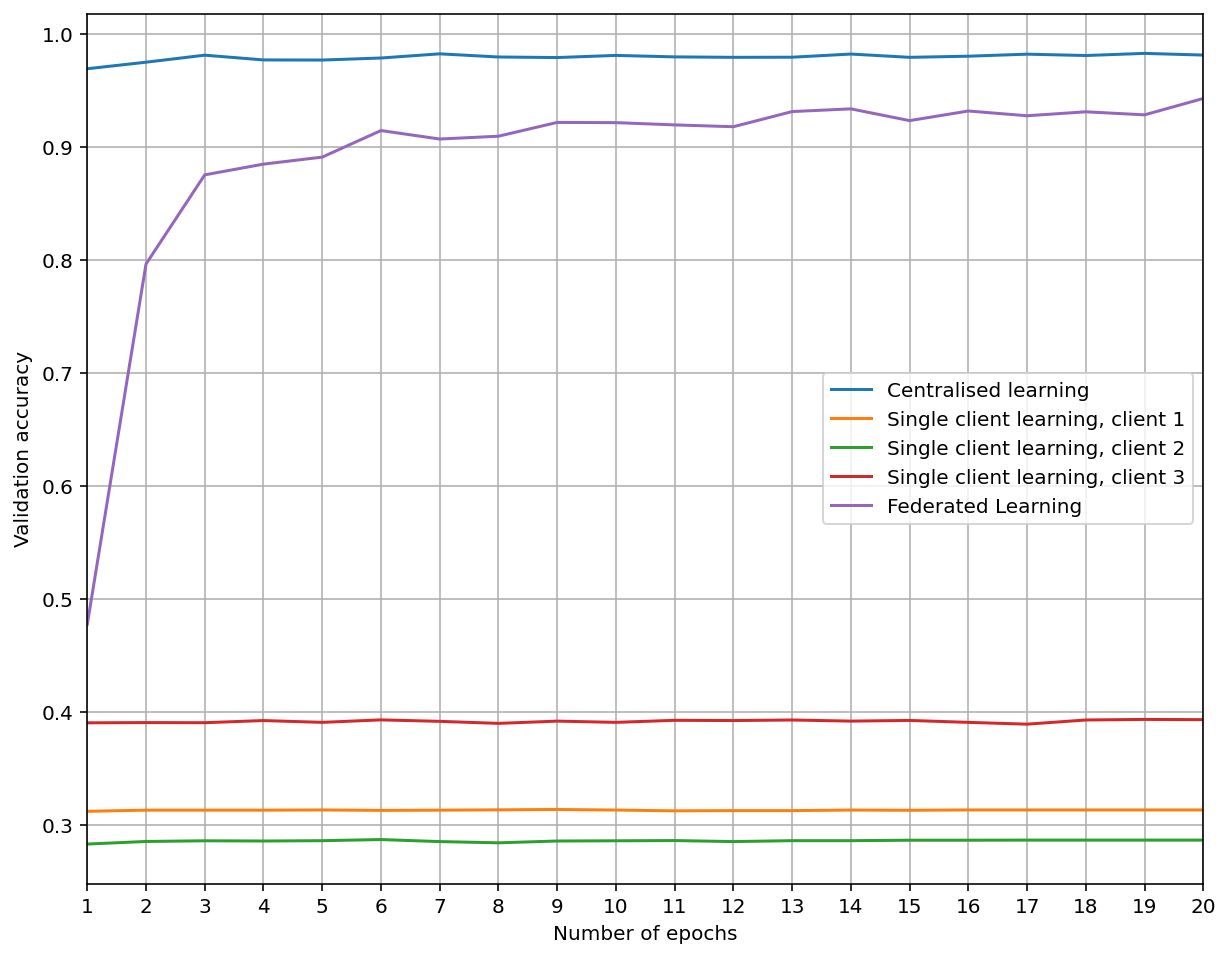

In [7]:
plt.figure(figsize=(10,8))
plt.plot(history_centralized.history['val_accuracy'],label='Centralised learning')

for i in range(len(X_clients)):
    plt.plot(history_clients[i].history['val_accuracy'],label='Single client learning, client '+str(i+1))
    
plt.plot(federated_learning,label='Federated Learning')
plt.xlabel('Number of epochs')
plt.ylabel('Validation accuracy')
plt.legend()
plt.grid()
plt.xticks(np.arange(0,21,1),np.arange(1,22,1))
plt.xlim(0,19)
plt.savefig('federated_learning_plot',dpi=300)
plt.show()

Let's comment these results.

By using only local data, we get models with an accuracy between 30% and 40%. (they only have 3 or four digits data).
The model will never predict correctly other digits as it has never seen them.

Putting all data toghether (centralised model), we have a ~99% accuracy. However at the cost to transfer our data to a central server, with high risk for our privacy.

Federated Learning here is the key: People share the model architecture and train models locally, by using only their data. After that, we only transfer trained parameters to a central server that aggregates them (averaging them for instance). Once the federated model has been built it can be deployed globally. Such a process can be iterated several times to increase accuracy.

The final model has comparable performances to the centralised model ones! Without sharing of any data.